In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Linear Algebra

## Q1: Condition number

For a linear system, ${\bf A x} = {\bf b}$, we can only solve for $x$ if the determinant of the matrix ${\bf A}$ is non-zero.  If the determinant is zero, then we call the matrix _singular_.  The _condition number_ of a matrix is a measure of how close we are to being singular.  The formal definition is:
\begin{equation}
\mathrm{cond}({\bf A}) = \| {\bf A}\| \| {\bf A}^{-1} \|
\end{equation}
But we can think of it as a measure of how much ${\bf x}$ would change due to a small change in ${\bf b}$.  A large condition number means that our solution for ${\bf x}$ could be inaccurate.

A _Hilbert matrix_ has $H_{ij} = (i + j + 1)^{-1}$, and is known to have a large condition number.  Here's a routine to generate a Hilbert matrix

In [2]:
def hilbert(n):
    """ return a Hilbert matrix, H_ij = (i + j - 1)^{-1} """

    H = np.zeros((n,n), dtype=np.float64)

    for i in range(1, n+1):
        for j in range(1, n+1):
            H[i-1,j-1] = 1.0/(i + j - 1.0)
    return H

Let's solve ${\bf Hx} ={\bf b}$.  Create a linear system by picking an ${\bf x}$ and generating a ${\bf b}$ by multiplying by the matrix ${\bf H}$.  Then use the `scipy.linalg.solve()` function to recover ${\bf x}$.  Compute the error in ${\bf x}$ as a function of the size of the matrix.

You won't need a large matrix, $n \sim 13$ or so, will start showing big errors.

You can compute the condition number with `numpy.linalg.cond()`

There are methods that can do a better job with nearly-singular matricies.  Take a look at `scipy.linalg.lstsq()` for example.

In [7]:
x = np.arange(13)
A = hilbert(13)

In [9]:
b = A @ x
import scipy.linalg
x = scipy.linalg.lstsq(A, b)
x

(array([  1.20651400e-07,   9.99985193e-01,   2.00044484e+00,
          2.99430401e+00,   4.03835041e+00,   4.85081620e+00,
          6.34405283e+00,   6.55787325e+00,   8.20220729e+00,
          9.23611572e+00,   9.58340889e+00,   1.12467970e+01,
          1.19456441e+01]),
 array([], dtype=float64),
 12,
 array([  1.81383012e+00,   3.96833076e-01,   4.90294194e-02,
          4.34875507e-03,   2.95177714e-04,   1.56237036e-05,
          6.46641856e-07,   2.07632142e-08,   5.07655186e-10,
          9.14127833e-12,   1.14354232e-13,   8.87566335e-16,
          3.19134976e-18]))

# FFTs

## Q2: Noisy signal

A convolution is defined as:                                                             
  \begin{equation}                                                                           
    (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau                   
  \end{equation}                                                                             
  It is easy to compute this with FFTs, via the {\em convolution theorem},                                                                        
  \begin{equation}                                                                                                                                                  
    \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\}                                                                                                 
  \end{equation}                                                                                                                                                    
  That is the Fourier transform of the convolution of $f$ and $g$ is simply
  the product of the individual transforms of $f$ and $g$.  This allows us
  to compute the convolution via multiplication in Fourier space and then take
  the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution                   in real space:                                                                             
  \begin{equation}                                                                               f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\}                     \end{equation}            
  
A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian.  We'll do that here.

Here's some noisy data we'll work with

In [3]:
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

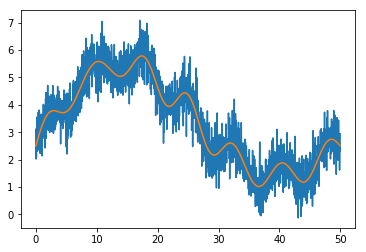

In [4]:
plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

## <span class="fa fa-star"></span> Q3: FFT of chaotic pendulum

Last time we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [5]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [6]:
t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

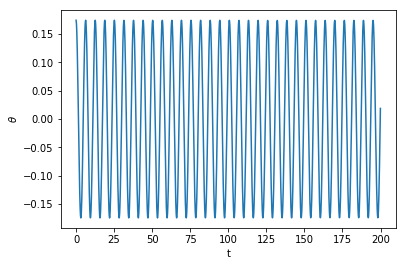

In [7]:
plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

In [8]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)
    
    # fill in the rest -- take the FFT of theta and return omega_k and 
    # the transform of theta


# Fitting

## Q4: Let's find the errors on our fit

We looked at fits, but not what the errors are on the fit.  Look at `scipy.optimize.curve_fit()`.  This is a simplified wrapper on the least squares fitting.  It can return the convariance matrix, the diagonals of which can give the error of the fit for the parameters.  

Make up some data that models a non-linear function (by introducing some random noise) and perform a fit and find the errors on the parameters.